In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import math

# For reproducibility
np.random.seed(7)

Matplotlib is building the font cache; this may take a moment.


In [4]:
import mosek

In [5]:
from tqdm import tqdm

In [6]:
_SOLVERS = cp.installed_solvers()
if "MOSEK" in _SOLVERS:
    SOLVER = "MOSEK"
else:
    SOLVER = "SCS"  # fallback
print("Using solver:", SOLVER)

Using solver: MOSEK


In [7]:
# -------------------------
# Fock basis helpers
# -------------------------
def destroy(d: int) -> np.ndarray:
    """Single-mode annihilation operator a in Fock basis with cutoff d."""
    a = np.zeros((d, d), dtype=complex)
    n = np.arange(1, d, dtype=float)
    a[:-1, 1:] = np.diag(np.sqrt(n))
    return a

def create(d: int) -> np.ndarray:
    return destroy(d).conj().T

def kron(*ops) -> np.ndarray:
    """Kronecker product of multiple operators."""
    out = np.array([[1+0j]])
    for X in ops:
        out = np.kron(out, X)
    return out

def partial_trace(rho: np.ndarray, dims, keep):
    """
    Partial trace over subsystems not in `keep`.
    dims: list/tuple of subsystem dims, e.g., [dA, dB]
    keep: list of subsystem indices to keep, e.g., [1] keeps B.
    """
    dims = list(dims)
    N = len(dims)
    keep = list(keep)
    trace = [i for i in range(N) if i not in keep]
    # Reshape rho into 2N indices
    rho_t = rho.reshape(*(dims + dims))
    # Move keep indices to front on both bra/ket
    idx_order = keep + trace + [N + i for i in keep] + [N + i for i in trace]
    rho_perm = rho_t.transpose(idx_order)
    d_keep = int(np.prod([dims[i] for i in keep]))
    d_trace = int(np.prod([dims[i] for i in trace])) if trace else 1
    rho_perm = rho_perm.reshape(d_keep, d_trace, d_keep, d_trace)
    # Trace out the 'trace' systems
    return np.einsum('ikjk->ij', rho_perm)

In [8]:
# -------------------------
# TMS state & loss channels
# -------------------------
def r_from_squeezing_db(s_db: float) -> float:
    # s_db = 10 log10(e^{-2 r})  =>  r = -0.5 * ln(10**(s_db/10))
    return -0.5 * np.log(10**(s_db/10.0))

def tms_state_density(d: int, s_db: float) -> np.ndarray:
    """Two-mode squeezed vacuum |psi> = sqrt(1-l^2) sum_n l^n |n,n>, cutoff d."""
    r = r_from_squeezing_db(s_db)
    lam = np.tanh(r)
    amps = np.array([np.sqrt(1 - lam**2) * lam**n for n in range(d)], dtype=complex)
    psi = np.zeros((d*d,), dtype=complex)
    for n in range(d):
        psi[n*d + n] = amps[n]
    rho = np.outer(psi, psi.conj())
    return rho

def loss_kraus_1mode(d: int, eta: float):
    """
    Pure-loss channel Kraus operators E_k (k=0..d-1) in Fock basis:
      E_k |n> = sqrt(C(n,k)) (1-η)^{k/2} η^{(n-k)/2} |n-k>, n>=k
    """
    Ks = []
    for k in range(d):
        K = np.zeros((d, d), dtype=complex)
        for n in range(k, d):
            coeff = np.sqrt(math.comb(n, k) * (1-eta)**k * eta**(n-k))
            K[n-k, n] = coeff
        Ks.append(K)
    return Ks

def apply_symmetric_loss(rho_AB: np.ndarray, d: int, eta: float) -> np.ndarray:
    EA = loss_kraus_1mode(d, eta)
    EB = loss_kraus_1mode(d, eta)
    out = np.zeros_like(rho_AB, dtype=complex)
    for k in range(d):
        KA = EA[k]
        for l in range(d):
            KB = EB[l]
            K = kron(KA, KB)
            out += K @ rho_AB @ K.conj().T
    return out

In [9]:
# -------------------------
# Quadrature & periodic binning POVM
# -------------------------
def quadrature_op(d: int, theta: float) -> np.ndarray:
    """x_theta = (a e^{-iθ} + a† e^{iθ}) / sqrt(2)."""
    a = destroy(d)
    adag = a.conj().T
    return (np.exp(-1j*theta)*a + np.exp(1j*theta)*adag) / np.sqrt(2.0)

def periodic_binning_povms(d: int, theta: float, T: float, o: int):
    """
    Build periodic-binning POVM {M_a} for quadrature at angle theta:
      - Diagonalize x_θ
      - Assign eigenmodes to bins by eigenvalue modulo T
    Returns list [M_0,...,M_{o-1}] each d×d (PSD), with sum ≈ I.
    """
    X = quadrature_op(d, theta)
    # Hermitian projection
    Xh = 0.5*(X + X.conj().T)
    vals, vecs = np.linalg.eigh(Xh)
    # Bin by modulo T
    width = T / o
    mvals = np.mod(vals, T)
    idxs = np.minimum((mvals / width).astype(int), o-1)

    Ms = [np.zeros((d, d), dtype=complex) for _ in range(o)]
    for j in range(d):
        v = vecs[:, j:j+1]
        Pj = v @ v.conj().T
        Ms[idxs[j]] += Pj

    # Light normalization (enforce Σ_a M_a ≈ I)
    S = sum(Ms)
    # Pseudo-inverse "balancing"
    Sinv = np.linalg.pinv(S)
    Ms = [Sinv @ M @ Sinv.conj().T for M in Ms]
    return Ms

In [10]:
# -------------------------
# Assemblage (tomography case)
# -------------------------
def assemblage_tomography(rho_AB: np.ndarray, d: int, Tq: float, oA: int = 8):
    """
    Alice settings: x=0 (θ=0, q), x=1 (θ=π/2, p).
    σ_{a|x} = Tr_A[ (M_{a|x} ⊗ I) ρ_AB ].
    Return sigma_obs[x][a] as d×d PSD matrices.
    """
    thetas = [0.0, np.pi/2]
    I_B = np.eye(d, dtype=complex)
    sigma = []
    for theta in thetas:
        Ms = periodic_binning_povms(d, theta, Tq, oA)
        row = []
        for Ma in Ms:
            Tau = kron(Ma, I_B) @ rho_AB @ kron(Ma, I_B).conj().T
            sig = partial_trace(Tau, [d, d], keep=[1])  # keep Bob
            row.append(sig)
        sigma.append(row)
    return sigma

def normalize_per_x(sigma):
    """Normalize assemblage so that Σ_a Tr σ_{a|x} = 1 for each x."""
    out = []
    for x in range(len(sigma)):
        total = sum(np.trace(sigma[x][a]).real for a in range(len(sigma[x])))
        out.append([sigma[x][a]/total for a in range(len(sigma[x]))])
    return out

In [11]:
# -------------------------
# SDP for Eq. (2) — tomography case
# -------------------------
def guessing_prob_sdp_tomography(sigma_obs, x_star=0, solver=SOLVER, verbose=False):
    """
    Primal SDP (Eq. (2) in Ioannou et al.):
      maximize   Σ_e Tr[ σ_e[e|x*] ]
      s.t.       Σ_e σ_e[a|x] = σ_obs[a|x]          (∀ a,x)
                 Σ_a σ_e[a|x] independent of x      (no-signalling)
                 σ_e[a|x] ⪰ 0
    sigma_obs[x][a] are d×d PSD numpy arrays.
    """
    mX = len(sigma_obs)       # e.g., 2 (q, p)
    mA = len(sigma_obs[0])    # e.g., 8 bins
    d  = sigma_obs[0][0].shape[0]

    # Variables σ_e[a|x]
    sigma_e = [[[cp.Variable((d, d), hermitian=True)
                 for _ in range(mX)] for _ in range(mA)] for _ in range(mA)]
    cons = []

    # (i) Consistency with observed assemblage
    for x in range(mX):
        for a in range(mA):
            lhs = sum(sigma_e[e][a][x] for e in range(mA))
            cons.append(lhs == sigma_obs[x][a])

    # (ii) No-signalling on Eve side: Σ_a σ_e[a|x] = Σ_a σ_e[a|x'] (indep. of x)
    ref = sum(sigma_e[0][a][0] for a in range(mA))
    for x in range(mX):
        lhs = sum(sigma_e[0][a][x] for a in range(mA))
        cons.append(lhs == ref)

    # (iii) PSD constraints
    for e in range(mA):
        for x in range(mX):
            for a in range(mA):
                cons.append(sigma_e[e][a][x] >> 0)

    obj = cp.Maximize(sum(cp.trace(sigma_e[e][e][x_star]) for e in range(mA)))
    prob = cp.Problem(obj, cons)
    val = prob.solve(solver=getattr(cp, solver), verbose=verbose)
    return float(val), prob.status

In [12]:
def reproduce_fig2_tomography(
    d=12,                # Fock cutoff (↑ for accuracy, ↑ runtime)
    s_db=-4.0,           # squeezing (variance dB)
    eta_grid=np.linspace(0.55, 1.0, 10),
    Tq_grid=np.linspace(2.0, 10.0, 9),
    oA=8,
    verbose=False
):
    """
    Sweep efficiency η and optimize H_min over Alice's periodic bin size T_q.
    Returns arrays Hmax[η], Tbest[η].
    """
    Hmax = []
    Tbest = []

    # Outer loop with progress bar
    for eta in tqdm(eta_grid, desc="Sweeping η", ncols=100):
        # 1) Build source and apply symmetric loss
        rho0 = tms_state_density(d, s_db)
        rho  = apply_symmetric_loss(rho0, d, eta)

        best_H = -np.inf
        best_T = None

        # 2) Scan Alice’s periodic bin size T_q
        for Tq in Tq_grid:
            sigma = assemblage_tomography(rho, d, Tq, oA=oA)
            sigma = normalize_per_x(sigma)

            # 3) SDP solve for guessing probability
            p_g, status = guessing_prob_sdp_tomography(
                sigma, x_star=0, solver=SOLVER, verbose=verbose
            )
            H = -np.log2(max(p_g, 1e-15))

            if H > best_H:
                best_H, best_T = H, Tq

        Hmax.append(best_H)
        Tbest.append(best_T)

        # Print summary per η
        print(f"η={eta:.3f}: max H_min={best_H:.5f} at T_q={best_T:.2f}")

    return np.array(Hmax), np.array(Tbest)

Sweeping η:   0%|                                                             | 0/5 [00:00<?, ?it/s]/var/folders/l4/4q021xd95fs5stqc1lplj25m0000gn/T/ipykernel_28477/1471357331.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(val), prob.status
Sweeping η:  20%|██████████▍                                         | 1/5 [06:29<25:58, 389.69s/it]

η=0.550: max H_min=0.00012 at T_q=6.00


Sweeping η:  40%|████████████████████▊                               | 2/5 [13:18<20:03, 401.20s/it]

η=0.663: max H_min=0.02850 at T_q=6.00


Sweeping η:  60%|███████████████████████████████▏                    | 3/5 [20:17<13:37, 408.96s/it]

η=0.775: max H_min=0.11514 at T_q=6.00


Sweeping η:  80%|█████████████████████████████████████████▌          | 4/5 [27:12<06:51, 411.46s/it]

η=0.887: max H_min=0.31205 at T_q=6.00


Sweeping η: 100%|████████████████████████████████████████████████████| 5/5 [33:47<00:00, 405.54s/it]

η=1.000: max H_min=0.91775 at T_q=10.00


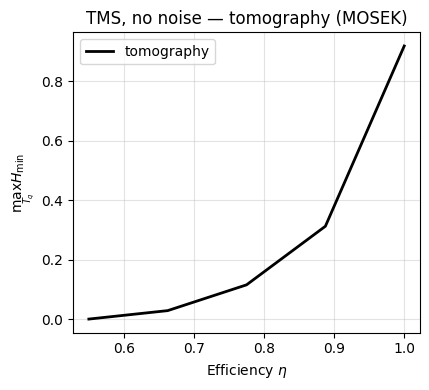

In [22]:
# -------------------------
# Run + plot
# -------------------------
eta_grid = np.linspace(0.55, 1.0, 5)

H_tomo, T_best = reproduce_fig2_tomography(
    d=8,
    s_db=-4.0,
    eta_grid=eta_grid,
    Tq_grid=np.linspace(2.0, 10.0, 5),
    oA=8,
    verbose=False
)


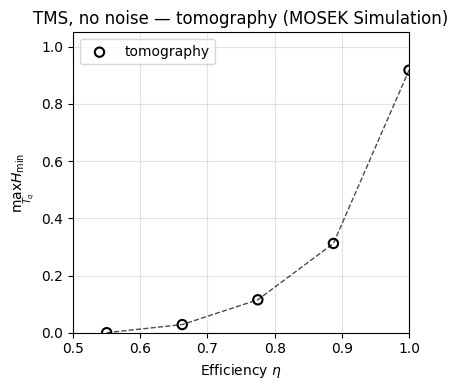

In [26]:
plt.figure(figsize=(4.4, 4.0))

plt.scatter(
    eta_grid, H_tomo,
    s=45, marker='o', facecolors='none', edgecolors='k', linewidths=1.5,
    label='tomography'
)

plt.plot(eta_grid, H_tomo, 'k--', lw=1, alpha=0.7)

plt.xlim(0.5, 1.0)
plt.ylim(0.0, 1.05)
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True, alpha=0.35)

plt.xlabel(r'Efficiency $\eta$')
plt.ylabel(r'$\max_{T_q} H_{\min}$')
plt.title('TMS, no noise — tomography (MOSEK Simulation)')
plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

In [27]:
def nonperiodic_binning_povms(d, theta, o, r):
    """
    Bob's binned homodyne POVM for quadrature at angle `theta` with `o` bins
    over [-r, r]. Values < -r are folded into the first bin, > r into the last bin.
    Implemented by diagonalizing x_theta in the truncated Fock space and grouping
    eigenmodes by bin.
    """
    X = quadrature_op(d, theta)
    Xh = 0.5*(X + X.conj().T)
    vals, vecs = np.linalg.eigh(Xh)

    edges = np.linspace(-r, r, o+1)
    # bin index: 0..o-1, with clipping outside [-r,r]
    idxs = np.searchsorted(edges, vals, side='right') - 1
    idxs = np.clip(idxs, 0, o-1)

    Ns = [np.zeros((d, d), dtype=complex) for _ in range(o)]
    for j in range(d):
        v = vecs[:, j:j+1]
        Pj = v @ v.conj().T
        Ns[idxs[j]] += Pj

    # light renormalization to make sum_b N_{b|y} ≈ I
    S = sum(Ns)
    Sinv = np.linalg.pinv(S)
    Ns = [Sinv @ N @ Sinv.conj().T for N in Ns]
    return Ns

def estimate_range_r(rho_AB, d):
    """
    Pick a reasonable finite bin range r from the second moment of Bob's x quadrature.
    We use theta=0 (q) and set r ≈ 6 * sigma_x to cover most of the mass.
    """
    X0 = quadrature_op(d, 0.0)
    I_A = np.eye(d, dtype=complex)
    X_op = kron(I_A, X0)
    mean = np.real(np.trace(X_op @ rho_AB))
    var  = np.real(np.trace((X_op @ X_op) @ rho_AB)) - mean**2
    sigma = np.sqrt(max(var, 1e-12))
    return 6.0 * sigma

In [28]:
def joint_probabilities(rho_AB, M_ax_list, N_by_list):
    """
    Compute P[a,b,x,y] = Tr[(M_{a|x} ⊗ N_{b|y}) ρ_AB]
    M_ax_list[x][a] and N_by_list[y][b] are POVM elements on A and B, respectively.
    Returns array with shape (mX, oA, mB, oB).
    """
    mX = len(M_ax_list)
    oA = len(M_ax_list[0])
    mB = len(N_by_list)
    oB = len(N_by_list[0])

    P = np.zeros((mX, oA, mB, oB))
    for x in range(mX):
        for a in range(oA):
            Ma = M_ax_list[x][a]
            for y in range(mB):
                for b in range(oB):
                    Nb = N_by_list[y][b]
                    K = kron(Ma, Nb)
                    P[x, a, y, b] = np.real(np.trace(K @ rho_AB))
    return P

In [29]:
def guessing_prob_sdp_homodyne(P, N_by_list, x_star=0, solver=None, verbose=False,
                               mosek_params=None, scs_params=None):
    """
    SDP for Eve's guessing probability when Bob uses m_B homodyne POVMs (binned).
      maximize   sum_e Tr( sigma_e[e|x*] )
      s.t.       sum_e Tr( N_{b|y} * sigma_e[a|x] ) = P[a,b,x,y]   ∀ a,b,x,y
                 sum_a sigma_e[a|x] independent of x               (no-signalling)
                 sigma_e[a|x] >= 0
    Inputs:
      P:          array with shape (mX, oA, mB, oB) of probabilities
      N_by_list:  list over y of lists {N_{b|y}} (each d×d PSD) on Bob
    """
    if solver is None:
        # use global SOLVER from earlier cells if present, else pick SCS
        try:
            from builtins import SOLVER as _S
            solver = _S
        except Exception:
            solver = "SCS"

    mX, oA, mB, oB = P.shape
    d = N_by_list[0][0].shape[0]

    # Decision variables σ_e[a|x] ∈ C^{d×d}, with e in {0,...,oA-1}
    sigma_e = [[[cp.Variable((d, d), hermitian=True)
                 for _ in range(mX)] for _ in range(oA)] for _ in range(oA)]
    cons = []

    # (i) Probability-matching constraints via Bob's POVMs
    for x in range(mX):
        for a in range(oA):
            Sig_ax = sum(sigma_e[e][a][x] for e in range(oA))  # Σ_e σ_e[a|x]
            for y in range(mB):
                for b in range(oB):
                    Nb = N_by_list[y][b]
                    cons.append(cp.real(cp.trace(Nb @ Sig_ax)) == P[x, a, y, b])

    # (ii) No-signalling on Eve's side: Σ_a σ_e[a|x] independent of x
    ref = sum(sigma_e[0][a][0] for a in range(oA))
    for x in range(mX):
        lhs = sum(sigma_e[0][a][x] for a in range(oA))
        cons.append(lhs == ref)

    # (iii) PSD
    for e in range(oA):
        for x in range(mX):
            for a in range(oA):
                cons.append(sigma_e[e][a][x] >> 0)

    obj = cp.Maximize(sum(cp.trace(sigma_e[e][e][x_star]) for e in range(oA)))
    prob = cp.Problem(obj, cons)

    if solver == "MOSEK":
        val = prob.solve(solver=cp.MOSEK, verbose=verbose,
                         mosek_params=(mosek_params or {
                             "MSK_DPAR_INTPNT_CO_TOL_REL_GAP": 1e-3,
                             "MSK_DPAR_INTPNT_CO_TOL_PFEAS": 1e-6,
                             "MSK_DPAR_INTPNT_CO_TOL_DFEAS": 1e-6,
                         }))
    elif solver == "SCS":
        val = prob.solve(solver=cp.SCS, verbose=verbose,
                         **(scs_params or {"eps": 1e-3, "max_iters": 5000}))
    else:
        val = prob.solve(solver=getattr(cp, solver), verbose=verbose)

    return float(np.real_if_close(val)), prob.status

In [30]:
def reproduce_fig2_homodyne_mb2(
    d=8,                         # start light; raise to 10–12 for closer match
    s_db=-4.0,
    eta_grid=np.linspace(0.55, 1.0, 5),
    Tq_grid=np.linspace(2.0, 10.0, 5),
    oA=8,                        # Alice periodic bins
    oB=16,                       # Bob non-periodic bins
    verbose=False
):
    # Bob's angles for m_B=2
    thetas_B = [0.0, np.pi/2]
    Hmax, Tbest = [], []

    for eta in eta_grid:
        # source + symmetric loss
        rho0 = tms_state_density(d, s_db)
        rho  = apply_symmetric_loss(rho0, d, eta)

        # choose finite range for Bob's non-periodic bins
        r = estimate_range_r(rho, d)

        # prebuild Bob's POVMs {N_{b|y}} for m_B=2
        N_by_list = [nonperiodic_binning_povms(d, th, oB, r) for th in thetas_B]

        best_H, best_T = -np.inf, None

        for Tq in Tq_grid:
            # Alice’s periodic-bin POVMs (tomography settings), build M_{a|x}
            thetas_A = [0.0, np.pi/2]
            M_ax_list = [periodic_binning_povms(d, th, Tq, oA) for th in thetas_A]

            # joint probabilities P[a,b,x,y]
            P = joint_probabilities(rho, M_ax_list, N_by_list)

            # SDP with probability constraints
            p_g, status = guessing_prob_sdp_homodyne(
                P, N_by_list, x_star=0, solver=SOLVER, verbose=verbose
            )
            H = -np.log2(max(p_g, 1e-15))
            if H > best_H:
                best_H, best_T = H, Tq

        Hmax.append(best_H)
        Tbest.append(best_T)
        print(f"η={eta:.3f}: m_B=2  max H_min={best_H:.4f} at T_q={best_T:.2f}")

    return np.array(Hmax), np.array(Tbest)

In [33]:
eta_grid = np.linspace(0.55, 1.0, 5)

H_mb2, Tbest_mb2 = reproduce_fig2_homodyne_mb2(
    d=8, s_db=-4.0,
    eta_grid=eta_grid,
    Tq_grid=np.linspace(2.0, 10.0, 5),
    oA=6, oB=12,
    verbose=False
)

η=0.550: m_B=2  max H_min=-0.0000 at T_q=4.00
η=0.663: m_B=2  max H_min=-0.0000 at T_q=10.00
η=0.775: m_B=2  max H_min=0.0222 at T_q=8.00
η=0.887: m_B=2  max H_min=0.0967 at T_q=8.00
η=1.000: m_B=2  max H_min=0.4555 at T_q=4.00


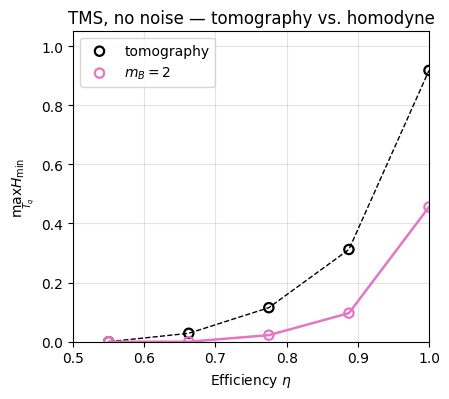

In [34]:
plt.figure(figsize=(4.6, 4.1))

plt.scatter(
    eta_grid, H_tomo,
    s=45, marker='o', facecolors='none', edgecolors='k', linewidths=1.6,
    label='tomography'
)
plt.plot(eta_grid, H_tomo, 'k--', lw=1)
plt.scatter(
    eta_grid, H_mb2,
    s=45, marker='o', facecolors='none', edgecolors='tab:pink', linewidths=1.6,
    label=r'$m_B=2$'
)
plt.plot(eta_grid, H_mb2, color='tab:pink', lw=1.8)

plt.xlim(0.5, 1.0)
plt.ylim(0.0, 1.05)
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True, alpha=0.35)

plt.xlabel(r'Efficiency $\eta$')
plt.ylabel(r'$\max_{T_q} H_{\min}$')
plt.title('TMS, no noise — tomography vs. homodyne')
plt.legend(loc='upper left', frameon=True)

plt.tight_layout()
plt.show()